In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

biscobis = pd.read_excel('/Users/fabicampanari/Desktop/project_4-Logistic-Regression/Biscobis.xlsx')
biscobis

,ident,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,1,4.1,0.6,6.9,4.7,2.4,2.3,5.2,0,32,4.2,1,0,1,1
1,5,6.0,0.9,9.6,7.8,3.4,4.6,4.5,0,58,6.8,1,0,1,3
2,7,4.6,2.4,9.5,6.6,3.5,4.5,7.6,0,46,5.8,1,0,1,1
3,9,5.5,1.6,9.4,4.7,3.5,3.0,7.6,0,63,5.4,1,0,1,3
4,11,2.4,1.6,8.8,4.8,2.0,2.8,5.8,0,32,4.3,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,89,2.9,1.2,7.3,6.1,2.0,2.5,8.0,1,34,4.0,0,1,1,1
96,94,1.9,2.7,5.0,4.9,2.2,2.5,8.2,1,36,3.6,0,1,0,1
97,96,0.6,1.6,6.4,5.0,0.7,2.1,8.4,1,25,3.4,0,1,1,1
98,98,2.0,2.8,5.2,5.0,2.4,2.7,8.4,1,38,3.7,0,1,0,1


`Acima, estamos carregando o conjunto de dados Biscobis.`

In [11]:
# Criando a função stepwise dos problema
def stepwise_logistic_regression(X, y, 
                                 initial_list=[], 
                                 threshold_in=0.01, 
                                 threshold_out=0.05, 
                                 verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Adicionando variável: {} com p-value {:.6}'.format(best_feature, best_pval))

        # Backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Removendo variável: {} com p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

`Acima, estamos criando a função para o método stepwise.`

In [12]:
X = biscobis[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']] # Features
y = biscobis['x11'] # Target

features = stepwise_logistic_regression(X, y) # Selecionando as melhores targets
features # Exibindo os targets

Adicionando variável: x3 com p-value 1.11513e-07
Adicionando variável: x7 com p-value 3.44928e-05
Adicionando variável: x6 com p-value 0.00361573


['x3', 'x7', 'x6']

`Com base na função stepwise apresentada, as variáveis mais adequadas para o modelo são: x3, x6 e x7.`

In [13]:
X = biscobis[features] # Features selecionadas
y = biscobis['x11'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train_const).fit()

Optimization terminated successfully.
         Current function value: 0.191397
         Iterations 9


`Executando o algoritmo de aprendizado de máquina utilizando o método de regressão logística.`

In [14]:
pred = model.predict(X_test_const)
y_pred_class = (pred > 0.5).astype(int)
y_pred_class

83    0
53    1
70    0
45    1
44    1
39    1
22    1
80    0
10    1
0     1
18    1
30    1
73    0
33    1
90    0
4     1
76    0
77    0
12    1
31    1
dtype: int64

`Acima, estamos selecionando as variáveis de teste do target e classificando-as com base em sua probabilidade de pertencer à classe 1 ou 0. Se a probabilidade for maior que 0.5, a classe atribuída será 1; caso contrário, será 0.`

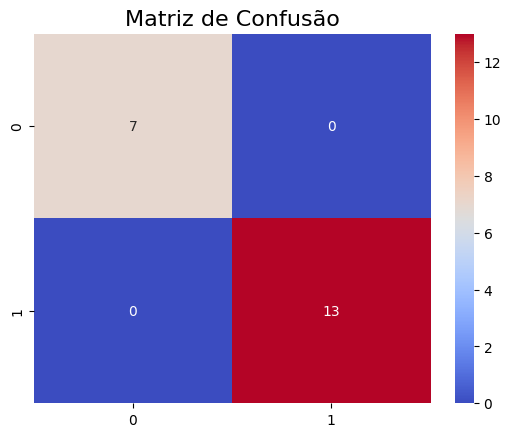

In [15]:
matriz = confusion_matrix(y_test, y_pred_class) # Criando a Matriz de confusão

sns.heatmap(matriz, annot=True, fmt='d', cmap = 'coolwarm') # Criando o gráfico da matriz de confusão
plt.title('Matriz de Confusão', fontsize=16) # Título do gráfico

plt.show()

`A matriz de confusão mostra que o modelo obteve uma precisão de 100% nas predições.`

In [16]:
# Log-verossimilhança do modelo nulo
ll_null = model.llnull

# Log-verossimilhança do modelo ajustado
ll_model = model.llf

n = biscobis.shape[0] # Número de observações

# Calcula a estatística de Nagelkerke
R2_nagelkerke = (1 - np.exp((ll_null - ll_model) * 2 / n)) / (1 - np.exp(ll_null * 2 / n))

# Exibe a estatística de Nagelkerke
print("Estatística de Nagelkerke:", R2_nagelkerke)

Estatística de Nagelkerke: 0.8169773897599528


`Analisando pela estimativa de Nagelkerke, que é similar ao R² na regressão linear, podemos afirmar que o modelo possui uma taxa de eficiência de aproximadamente 81,7% em suas predições.`

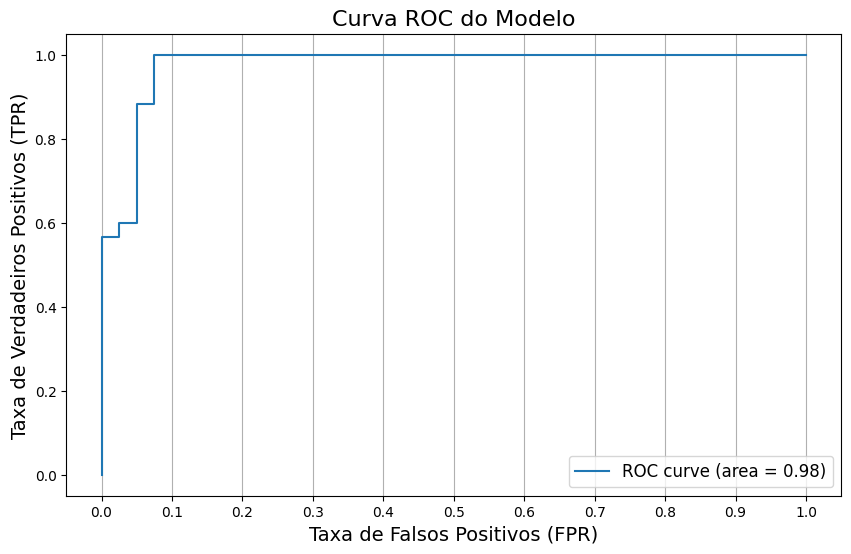

In [17]:
constant_X = sm.add_constant(X) # Adicionando a constante ao conjunto de teste

y_pred_constant = model.predict(constant_X) # Previsão para o conjunto de teste

# Calcula o FPR (Taxa de Falsos Positivos) e TPR (Taxa de Verdadeiros Positivos)
fpr, tpr, thresholds = roc_curve(y, y_pred_constant)

# Calcula a área sob a curva ROC (AUC)
accuracy_ROC = auc(fpr, tpr)


plt.figure(figsize=(10, 6)) # Tamanho da figura
plt.plot(fpr, tpr, label = f'ROC curve (area = {accuracy_ROC:.2f})') # Plota a curva ROC

plt.title('Curva ROC do Modelo', fontsize=16) # Título do gráfico
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14) # Rótulo do eixo X
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14)
plt.xticks(np.arange(0, 1.1, 0.1)) # Rótulos do eixo X

plt.legend(loc='lower right', fontsize=12) # Legenda do gráfico

plt.grid(axis = 'x')
plt.show()

`De acordo com a curva ROC acima, podemos observar que o modelo tem um excelente desempenho na distinção entre as classes. Com uma AUC de 0,98, isso indica que o modelo possui uma ótima capacidade de separação entre as classes positivas e negativas.`